In [1]:
import glob
from itertools import chain
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import random
from sklearn.metrics import accuracy_score
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import torchvision as tv
from torchinfo import summary
from tqdm import notebook

from hidden_space_visualization import add_embedding

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# DEVICE = 'cpu'

# Dataset

In [2]:
BATCH_SIZE = 1024

with np.load('D:/Datasets/mnist.npz') as mnist:
    x_train, y_train, x_test, y_test = mnist['x_train'], mnist['y_train'], mnist['x_test'], mnist['y_test']

dataloader = torch.utils.data.DataLoader([*zip(x_train, y_train)], batch_size=BATCH_SIZE, shuffle=True)

# Models

In [2]:
H_DIM = 8
LEAKY = 0.1  # LeakyReLU coefficient
CHANNELS_IMG = 1

FEATURES_DISC = 32
FEATURES_GEN = 16

In [3]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(channels_img, features_d, 4, 2, 1), nn.LeakyReLU(LEAKY),
            self._block(features_d,     features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
#             self._block(features_d * 4, features_d * 8, 4, 2, 1),
            nn.Conv2d(  features_d * 4, 1             , 4, 2, 0), nn.Sigmoid(),
        )

    def forward(self, x):
        return self.conv(x)
    
    def _block(self, inp_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(inp_channels, out_channels, kernel_size, stride, padding, bias=False),
#             nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(LEAKY),
        )
    
discriminator = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(DEVICE)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))

# print(discriminator(torch.zeros((2, 1, 32, 32)).to(DEVICE)).shape)
summary(discriminator, (2, 1, 32, 32), verbose=0, depth=2, device=DEVICE)

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            --                        --
├─Sequential: 1-1                        [2, 1, 1, 1]              --
│    └─Conv2d: 2-1                       [2, 32, 16, 16]           544
│    └─LeakyReLU: 2-2                    [2, 32, 16, 16]           --
│    └─Sequential: 2-3                   [2, 64, 8, 8]             32,768
│    └─Sequential: 2-4                   [2, 128, 4, 4]            131,072
│    └─Conv2d: 2-5                       [2, 1, 1, 1]              2,049
│    └─Sigmoid: 2-6                      [2, 1, 1, 1]              --
Total params: 166,433
Trainable params: 166,433
Non-trainable params: 0
Total mult-adds (M): 8.67
Input size (MB): 0.01
Forward/backward pass size (MB): 0.23
Params size (MB): 0.67
Estimated Total Size (MB): 0.90

In [4]:
class Generator(nn.Module):
    def __init__(self, h_dim, channels_img, features_g):
        super().__init__()
        self.convT = nn.Sequential(
            self._block(h_dim,               features_g *16, 4, 1, 0),
            self._block(features_g * 16,     features_g * 8, 4, 2, 1),
            self._block(features_g * 8, features_g * 4, 4, 2, 1),
#             self._block(features_g * 4, features_g * 2, 4, 2, 1),
            nn.ConvTranspose2d(  features_g * 4, channels_img  , 4, 2, 1), nn.Tanh(),
        )
        
    def forward(self, x):
        return self.convT(x.unsqueeze(-1).unsqueeze(-1))
    
    def _block(self, inp_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(inp_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
#             nn.LeakyReLU(LEAKY),
            nn.ReLU(),
        )
    
generator = Generator(H_DIM, CHANNELS_IMG, FEATURES_GEN).to(DEVICE)
optimizer_g = torch.optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))

# print(generator(torch.randn((2, H_DIM)).to(DEVICE)).shape)
summary(generator, (2, H_DIM), verbose=0, depth=2, device=DEVICE)

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                --                        --
├─Sequential: 1-1                        [2, 1, 32, 32]            --
│    └─Sequential: 2-1                   [2, 256, 4, 4]            33,280
│    └─Sequential: 2-2                   [2, 128, 8, 8]            524,544
│    └─Sequential: 2-3                   [2, 64, 16, 16]           131,200
│    └─ConvTranspose2d: 2-4              [2, 1, 32, 32]            1,025
│    └─Tanh: 2-5                         [2, 1, 32, 32]            --
Total params: 690,049
Trainable params: 690,049
Non-trainable params: 0
Total mult-adds (M): 137.37
Input size (MB): 0.00
Forward/backward pass size (MB): 0.93
Params size (MB): 2.76
Estimated Total Size (MB): 3.69

## Models weights initialization

In [ ]:
## DISCRIMINATOR
# for layer in chain(discriminator.conv.children()):
#     if isinstance(layer, (nn.ConvTranspose2d, nn.Conv2d, nn.Linear, nn.BatchNorm2d)):
#         nn.init.normal_(layer.weight, 0, 0.02)

## GENERATOR
for layer in chain(generator.convT.children()):
    if isinstance(layer, (nn.ConvTranspose2d, nn.Conv2d, nn.Linear, nn.BatchNorm2d)):
        nn.init.normal_(layer.weight, 0, 0.02)

## Learning Rate

In [11]:
# GET DISCRIMINATOR LR

for pg in optimizer_d.param_groups:
    print(pg['lr'])

0.0005


In [25]:
# CHANGE DISCRIMINATOR LR

for pg in optimizer_d.param_groups:
    pg['lr'] = 2e-4

In [12]:
# GET GENERATOR LR

for pg in optimizer_g.param_groups:
    print(pg['lr'])

0.0003


In [26]:
# CHANGE GENERATOR LR

for pg in optimizer_g.param_groups:
    pg['lr'] = 2e-4

# Tensorboard

In [5]:
tb = SummaryWriter('runs/DCGAN_MNIST/fake')

In [81]:
tb.close()

# Training

In [9]:
step = 1

In [6]:
FIXED_NOISE = torch.randn(24, H_DIM).to(DEVICE)  # hidden points for samples

In [ ]:
EPOCHS = 100
MONITORING_INTERVAL = 1  # epoch interval to save result images eamples
SAVE_INTERVAL = 0  # save model weights and optimizer state every SAVE_INTERVAL epoch; use 0 for no save

for epoch in range(EPOCHS):
    pbar = notebook.tqdm(dataloader)
    pbar.color='red'
    for batch_idx, (x_real, lbl) in enumerate(pbar):
        pbar.set_description(f'EPOCHE={epoch + 1}')

        x_real = x_real / 255.
        x_real = x_real * 2 - 1
        x_real = x_real.unsqueeze(1).to(DEVICE, dtype=torch.float)
        x_real = tv.transforms.Resize(32)(x_real)
        
        batch_size = x_real.shape[0]
        noise = torch.randn((batch_size, H_DIM)).to(DEVICE)  # batch_size // 10
        
        ## DISCRIMINATOR
        discriminator.train()
        generator.eval()
        fake = generator(noise)

        discriminator_real = discriminator(x_real).view(-1)
        discriminator_fake = discriminator(fake).view(-1)
        loss_d_real = nn.BCELoss()(discriminator_real, torch.ones_like(discriminator_real, device=DEVICE))
        loss_d_fake = nn.BCELoss()(discriminator_fake, torch.zeros_like(discriminator_fake, device=DEVICE))
        loss_d = (loss_d_real + loss_d_fake) / 2
        discriminator.zero_grad()
        loss_d.backward()
        optimizer_d.step()
        
        accuracy_d = accuracy_score(torch.cat([discriminator_real, discriminator_fake], dim=0).detach().round().to('cpu'), 
                                    torch.cat([torch.ones_like(discriminator_real), torch.zeros_like(discriminator_fake)], dim=0).detach().round().to('cpu'))
        
        ## GENERATOR
        discriminator.eval()
        generator.train()
        fake = generator(noise)
        
        output = discriminator(fake).view(-1)
        loss_g = nn.BCELoss()(output, torch.ones_like(output, device=DEVICE))
        generator.zero_grad()
        loss_g.backward()
        optimizer_g.step()
        
        ## MONITORING
        pbar.set_postfix({'accuracy_d->': accuracy_d, 'loss_d->': float(loss_d), 'loss_g->': float(loss_g), 'step->': str(step)})
        
        step += 1


    ## SAVE IMAGES EXAMPLES
    if MONITORING_INTERVAL and not epoch % MONITORING_INTERVAL:
        generator.eval()
        with torch.no_grad():
            tb.add_images('DCGAN FAKE', ((generator(FIXED_NOISE) + 1) / 2).detach().view(-1, 1, 32, 32), global_step=step - 1)

    ## SAVE MODEL WEIGHTS AND OPTIMIZER STATE
    if SAVE_INTERVAL and not epoch % SAVE_INTERVAL:
        torch.save({
            'discriminator': discriminator.state_dict(), 
            'optimizer_d': optimizer_d.state_dict(),
            'generator': generator.state_dict(), 
            'optimizer_g': optimizer_g.state_dict(),
            }, f'checkpoints/weights_DCGAN-MNIST-hdim{H_DIM}-step{step - 1}.pth')

In [7]:
## LOAD

params = torch.load('checkpoints/_weights_DCGAN-MNIST_generator_only_hdim8-3.pth', map_location=DEVICE)

generator.load_state_dict(params)  # for `generator_only` weights

# discriminator.load_state_dict(params['discriminator'])
# generator.load_state_dict(params['generator'])
# optimizer_d.load_state_dict(params['optimizer_d'])
# optimizer_g.load_state_dict(params['optimizer_g'])

<All keys matched successfully>

# Let's Play

In [8]:
generator.eval();

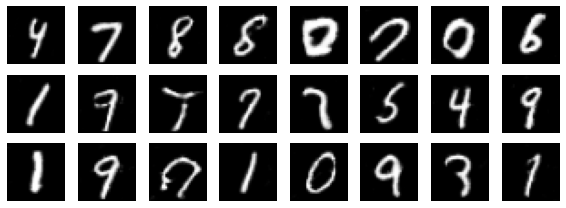

In [10]:
## Plot examples

fig, axs = plt.subplots(3, 8, figsize=(8, 3))
with torch.no_grad():
    for ax, fake_i in zip(axs.ravel(), (generator(FIXED_NOISE).detach().to('cpu') + 1) / 2):
        ax.imshow(fake_i.permute(1, 2, 0), cmap='gray')
        ax.axis('off')
plt.tight_layout()

# Hidden space visualization

In [9]:
add_embedding(generator, summary_writer=tb, h_dim=H_DIM, tag='DCGAN_8D', device=DEVICE)

2732 samples is used.


## Estimate "cents of mass" of each digit (hoping for connectivity and unimodality)

In [10]:
FIXED_NOISE_BIG = torch.randn(600, H_DIM).to(DEVICE)

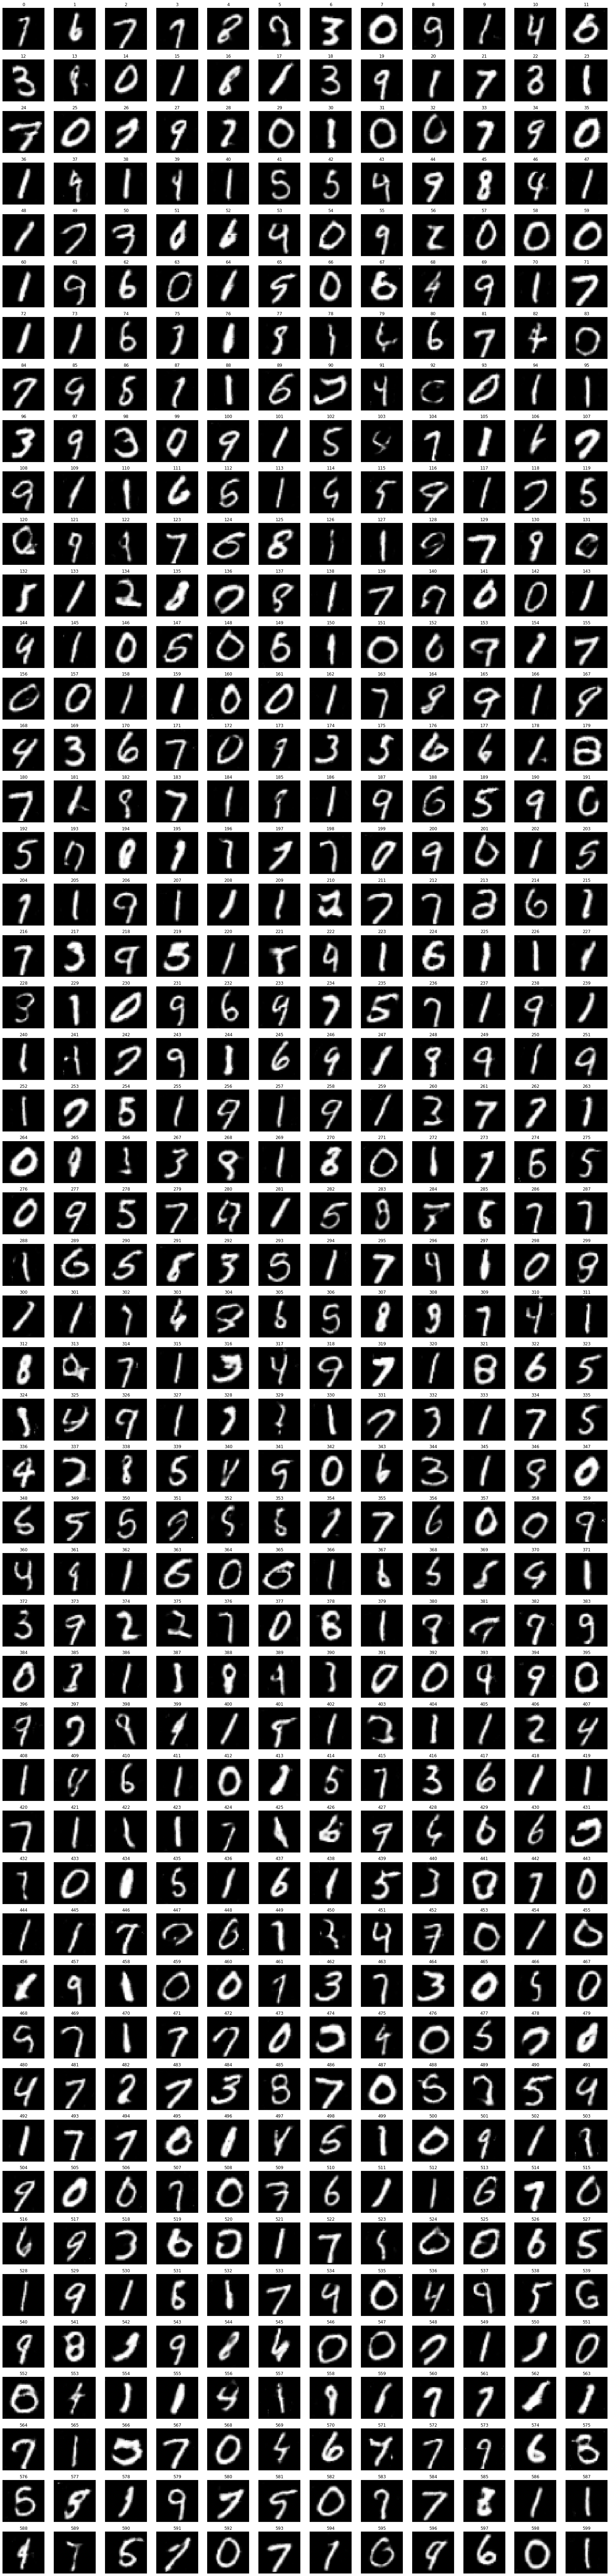

In [21]:
fig, axs = plt.subplots(50, 12, figsize=(12*2, 50*2))
with torch.no_grad():
    for i, (ax, fake_i) in enumerate(zip(axs.ravel(), generator(FIXED_NOISE_BIG).detach())):
        ax.imshow(fake_i.permute(1, 2, 0).to('cpu'), cmap='gray')
        ax.axis('off')
        ax.set_title(i)
plt.tight_layout()

In [ ]:
# Print estimated "center of mass" of target number for examples picked from big output from cell above
# (pick up image numbers of good examples on target numbers (you may use really good once multiple times))
FIXED_NOISE_BIG[[7,35,14,29,25,31,31,54,66,63,5,58,59,157,160,161,271,271,264,298,357,358,364,377,392,392,
395,395,412,412,433,443,459,459,459,450,467,476,476,508,535,535,546,546,547,551,568,568,582,582,592,592,598,598]].mean(dim=0)

In [11]:
def plot_point(pt: List[float]):
    """Plots digit generated from point pt of hidden space."""
    plt.imshow(
        generator(
            torch.tensor(pt, device=DEVICE).unsqueeze(0)
        ).squeeze().to('cpu').detach(),
        cmap='gray'
    )
    plt.gca().axis('off');

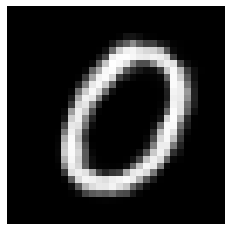

In [13]:
pt0 = np.array([-1.1571, -1.2077, -1.1134,  0.6138, -0.9859,  0.0506,  0.2869,  0.8213], dtype=np.float32)
plot_point(pt0)

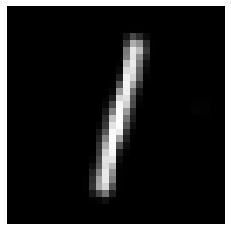

In [14]:
pt1 = np.array([ 0.3677,  0.7761,  0.6562,  0.0404,  0.1646, -0.6725, -0.4815, -0.0385], dtype=np.float32)
plot_point(pt1)

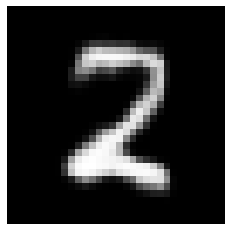

In [23]:
pt2 = np.array([-1.1291,  0.1414, -1.1457,  1.3694, -0.6417, -0.4106, -1.1939, -0.43212], dtype=np.float32)
plot_point(pt2)

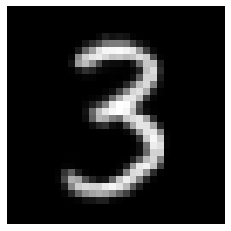

In [24]:
pt3 = np.array([-0.5316, -0.8380, -0.4783, -0.8721,  1.4406, -0.2672, -1.2375,  0.1057], dtype=np.float32)
plot_point(pt3)

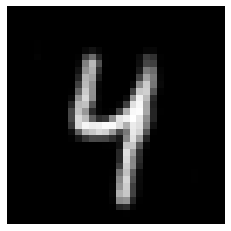

In [25]:
pt4 = np.array([ 0.0259,  0.5790,  0.3511,  0.1918,  0.5301, -0.0184,  1.2016, -0.9092], dtype=np.float32)
plot_point(pt4)

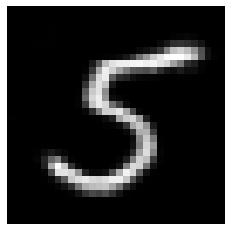

In [26]:
pt5 = np.array([-0.1274,  0.3306, -0.3068, -1.4572,  0.8012, -0.2938,  0.5386,  1.1186], dtype=np.float32)
plot_point(pt5)

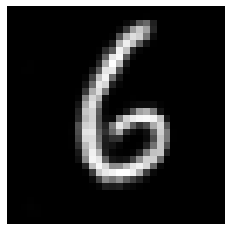

In [27]:
pt6 = np.array([-1.4481,  0.4128,  0.6160, -0.3175, -0.2645,  0.5060,  0.5764,  0.1143], dtype=np.float32)
plot_point(pt6)

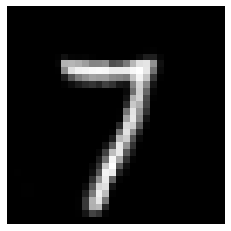

In [28]:
pt7 = np.array([ 1.1599,  0.2957, -0.1206,  1.0386, -0.4699,  0.2888, -0.5588, -0.9042], dtype=np.float32)
plot_point(pt7)

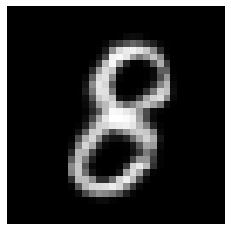

In [29]:
pt8 = np.array([-0.9818, -0.9515, -0.2580,  0.2583, -0.0739, -0.5604, -0.7784,  0.9940], dtype=np.float32)
plot_point(pt8)

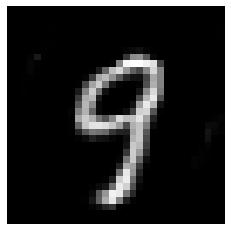

In [30]:
pt9 = np.array([ 0.1207, -1.7992,  0.0672, -0.0307,  0.2478, -1.1829,  1.8261,  0.7955], dtype=np.float32)
plot_point(pt9)

## Slices

### Plot line

In [16]:
def plot_line(x, y, n=30):
    """Plots lineslice (with n points) from one point of FIXED_NOISE_BIG to another."""
    line = torch.tensor(np.linspace(FIXED_NOISE_BIG[x].to('cpu').numpy(), FIXED_NOISE_BIG[y].to('cpu').numpy(), n), dtype=torch.float32)
    fig, axs = plt.subplots(1, len(line), figsize=(30,10))
    for ax, point in zip(axs, line):
        ax.imshow(generator(point.unsqueeze(0).to(DEVICE)).detach().to('cpu')[0].permute(1, 2, 0), cmap='gray')
        ax.axis('off')

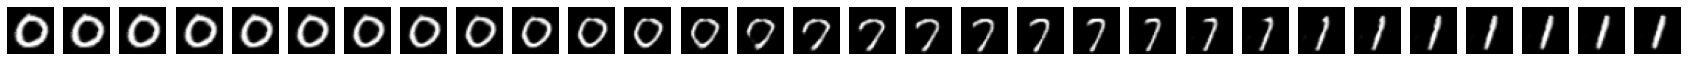

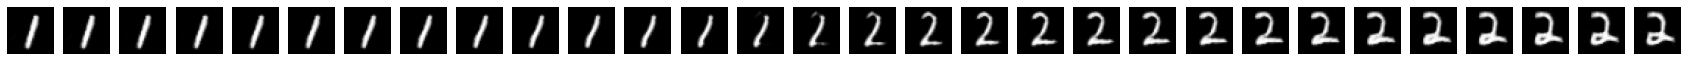

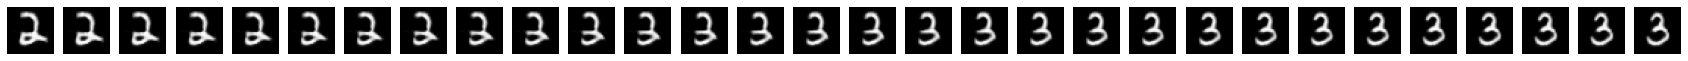

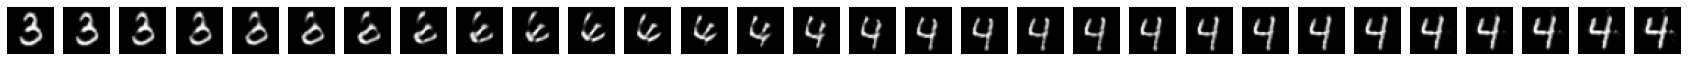

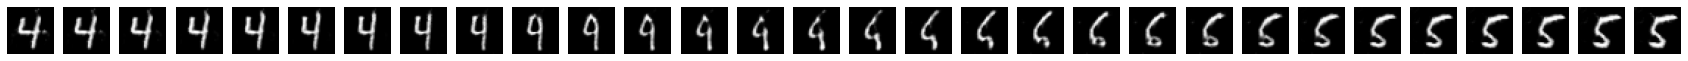

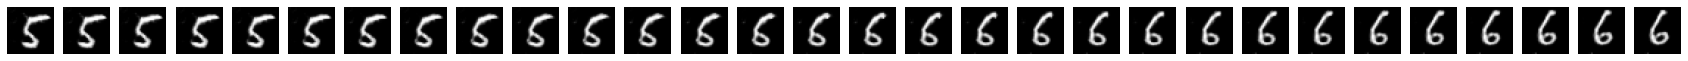

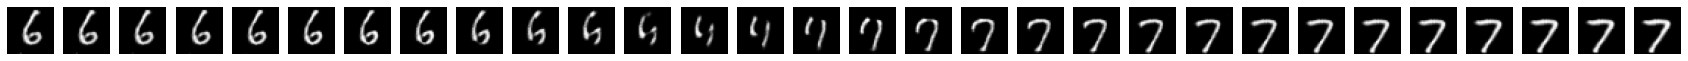

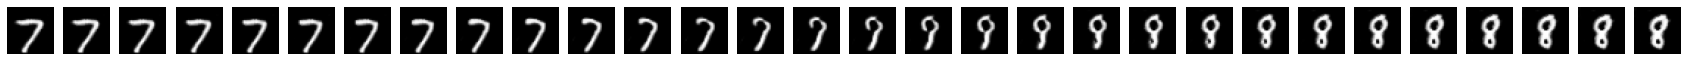

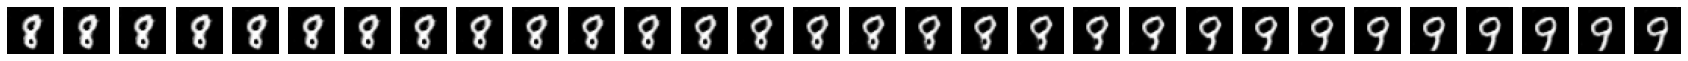

In [ ]:
plot_line(16, 6)  # 0-1
plot_line(6, 55)  # 1-2
plot_line(55, 42) # 2-3
plot_line(42, 48) # 3-4
plot_line(48, 27) # 4-5
plot_line(27, 54) # 5-6
plot_line(54, 22) # 6-7
plot_line(22, 35) # 7-8
plot_line(35, 37) # 8-9

### Generating slices numerical ordered way

In [ ]:
## RECORD FRAMES

POINTS = 50  # points into slice

points = torch.tensor(np.concatenate([
    np.linspace(pt0, pt1, POINTS),
    np.linspace(pt1, pt2, POINTS),
    np.linspace(pt2, pt3, POINTS),
    np.linspace(pt3, pt4, POINTS),
    np.linspace(pt4, pt5, POINTS),
    np.linspace(pt5, pt6, POINTS),
    np.linspace(pt6, pt7, POINTS),
    np.linspace(pt7, pt8, POINTS),
    np.linspace(pt8, pt9, POINTS),
    np.linspace(pt9, pt0, POINTS)
]), device=DEVICE, dtype=torch.float)

for i, p in enumerate(points):
#     plt.imshow(
#         generator(
#             p.unsqueeze(0)
#         ).squeeze().to('cpu').detach(),
#         cmap='gray'
#     )
#     plt.gca().axis('off');

    plt.imsave(f'frames/{str(i).zfill(3)}.png',
               generator(
            p.unsqueeze(0)
        ).squeeze().to('cpu').detach(),
        cmap='gray')

In [ ]:
## MAKE GIFS FROM FRAMES

img, *imgs = [PIL.Image.open(f) for f in sorted(glob.glob('frames/*.png'))]
img.save(fp='order.gif', format='GIF', append_images=imgs, save_all=True, duration=50, loop=1)

### Generating slices aproximatly closest way

In [31]:
## Prind distances matrix

def get_distances(pt):
    """Calculates and returns distances between pt point and calculated before center mass points."""
    return [np.linalg.norm(pt - p) for p in (pt0, pt1, pt2, pt3, pt4, pt5, pt6, pt7, pt8, pt9)]
    
with np.printoptions(linewidth=150):
    print(np.array([get_distances(p) for p in (pt0, pt1, pt2, pt3, pt4, pt5, pt6, pt7, pt8, pt9)]))

[[0.        3.5912347 2.5471237 3.4588952 3.6123335 3.4395308 2.8071892 3.5791566 1.8232423 3.0340042]
 [3.5912347 0.        3.0062435 2.813997  2.103346  2.557719  2.504858  2.1307948 2.6291916 3.65146  ]
 [2.5471237 3.0062435 0.        3.38137   3.5560696 4.151447  3.2464764 2.7510862 2.4062371 4.557899 ]
 [3.4588952 2.813997  3.38137   0.        3.465346  2.547704  3.2718585 3.6557965 2.2184284 3.8049536]
 [3.6123335 2.103346  3.5560696 3.465346  0.        2.8174667 2.2078652 2.549351  3.4546294 3.2444851]
 [3.4395308 2.557719  4.151447  2.547704  2.8174667 0.        2.585909  3.8952756 2.8117595 3.1034143]
 [2.8071892 2.504858  3.2464764 3.2718585 2.2078652 2.585909  0.        3.4076896 2.6376247 3.5886114]
 [3.5791566 2.1307948 2.7510862 3.6557965 2.549351  3.8952756 3.4076896 0.        3.3614697 4.2314224]
 [1.8232423 2.6291916 2.4062371 2.2184284 3.4546294 2.8117595 2.6376247 3.3614697 0.        3.0720022]
 [3.0340042 3.65146   4.557899  3.8049536 3.2444851 3.1034143 3.5886114 4

In [32]:
## RECORD FRAMES

POINTS = 50  # points into slice

points = torch.tensor(np.concatenate([
    np.linspace(pt0, pt8, POINTS),
    np.linspace(pt8, pt3, POINTS),
    np.linspace(pt3, pt5, POINTS),
    np.linspace(pt5, pt1, POINTS),
    np.linspace(pt1, pt4, POINTS),
    np.linspace(pt4, pt6, POINTS),
    np.linspace(pt6, pt2, POINTS),
    np.linspace(pt2, pt7, POINTS),
    np.linspace(pt7, pt9, POINTS),
    np.linspace(pt9, pt0, POINTS),
]), device=DEVICE, dtype=torch.float)

for i, p in enumerate(points):
    plt.imsave(f'frames/{str(i).zfill(3)}.png',
               generator(
            p.unsqueeze(0)
        ).squeeze().to('cpu').detach(),
        cmap='gray')

In [34]:
## MAKE GIFS FROM FRAMES

img, *imgs = [PIL.Image.open(f) for f in sorted(glob.glob('frames/*.png'))]
img.save(fp='close.gif', format='GIF', append_images=imgs, save_all=True, duration=50, loop=1)

## What's about H_DIM another than 8?

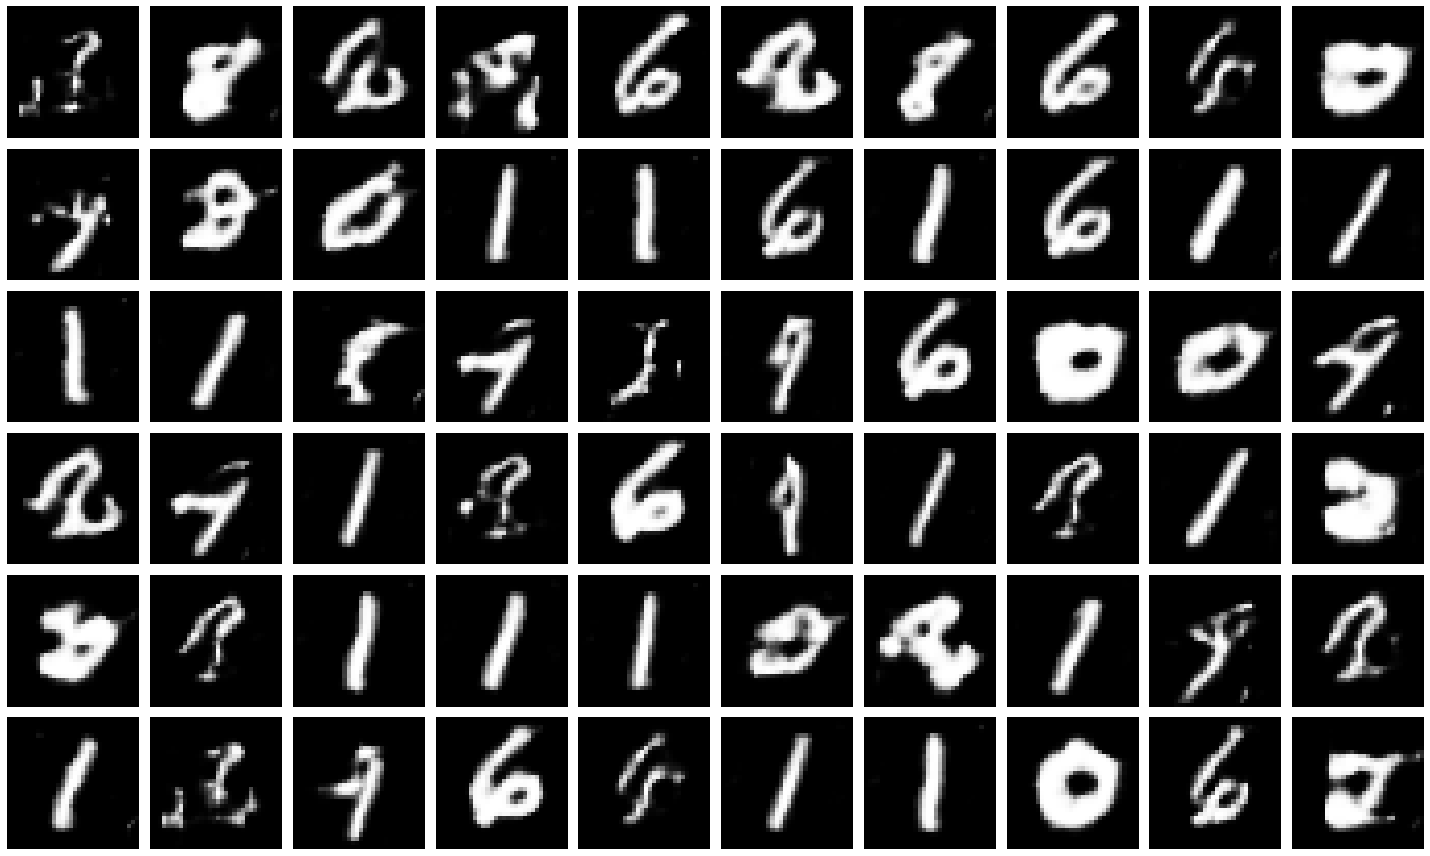

In [ ]:
# H_DIM = 2
fig, axs = plt.subplots(6, 10, figsize=(10 * 2, 6 * 2))
for ax, fake_i in zip(axs.ravel(), generator(FIXED_NOISE).detach()):
    ax.imshow(fake_i.permute(1, 2, 0).to('cpu'), cmap='gray')
    ax.axis('off')
plt.tight_layout()

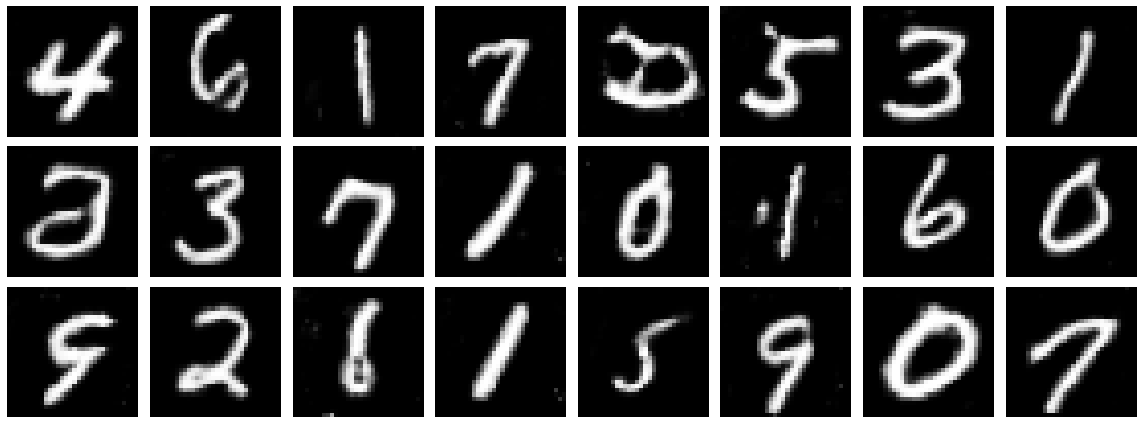

In [ ]:
# H_DIM = 5
fig, axs = plt.subplots(3, 8, figsize=(8 * 2, 3 * 2))
for ax, fake_i in zip(axs.ravel(), generator(FIXED_NOISE).detach()):
    ax.imshow(fake_i.permute(1, 2, 0).to('cpu'), cmap='gray')
    ax.axis('off')
plt.tight_layout()

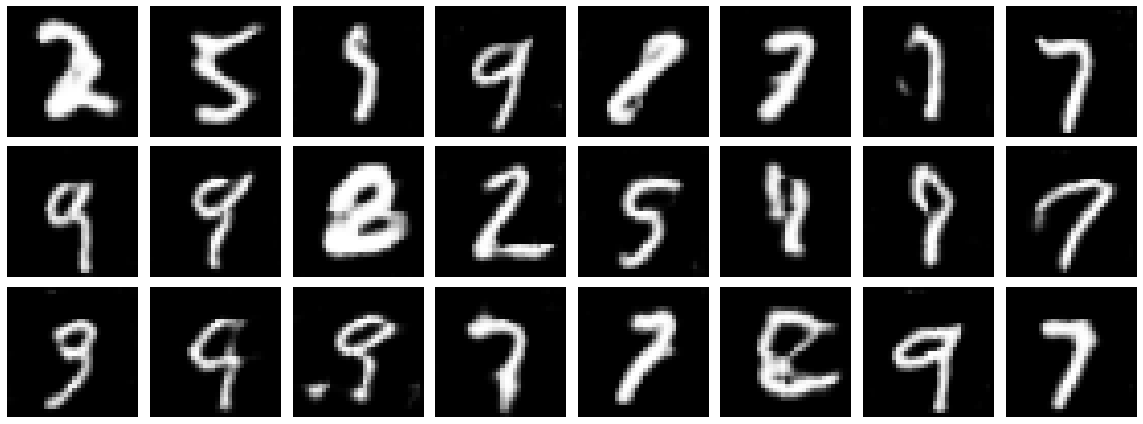

In [ ]:
# H_DIM = 128
fig, axs = plt.subplots(3, 8, figsize=(8 * 2, 3 * 2))
for ax, fake_i in zip(axs.ravel(), generator(FIXED_NOISE).detach()):
    ax.imshow(fake_i.permute(1, 2, 0).to('cpu'), cmap='gray')
    ax.axis('off')
plt.tight_layout()